# Make a dataset of text segments for specific attributes

Here's the "open" code for this, but bare in mind we refactored this into reusable tools in `mood`.

In [ ]:
datadir = '/Users/thorwhalen/Dropbox/Docs/Projects/mood/trump_vs_zelenskyy/data/'

In [ ]:
# The semantic attributes we'll build datasets for

semantic_attributes = dict(
    diplomatic_politeness="Diplomatic Politeness (Degree of formality, civility, and ceremonial tone. Example--It's an honor to have you here.)",
    military_intensity="Military Reference Intensity (Mentions of soldiers, arms, tactics, or losses. Example--Thousands of soldiers have died.)",
    blame_attribution="Blame Attribution (Assigning fault or responsibility. Example--Biden administration didn’t speak to Russia whatsoever.)",
    self_promotion="Self-Promotion / Credit Claiming (Speaker takes credit for progress or leadership. Example--We made a deal. That’s what changed.)",
    praise_admiration="Praise / Admiration (Expressions of respect for people or nations. Example--Your soldiers have been unbelievably brave.)",
    peace_appeal="Appeal to Peace / De-escalation (Rhetoric aimed at ending war or violence. Example--We want to stop the war.)",
    assertion_strength="Assertion Strength (Certainty, confidence, definitive tone. Example--It would have never happened.)",
    factual_speculative="Factual vs. Speculative (Degree of evidence-based vs. hypothetical claims. Example--If I were President, this war would never have happened.)",
    nationalistic_sentiment="Nationalistic Sentiment (Pride in national identity, culture, or values. Example--We are defending Europe.)",
    historical_framing="Historical Framing (References to past presidents, treaties, timelines. Example--We signed the deal in 2019.)",
    sentiment_polarity="Sentiment Polarity (Positive or negative affective tone. Example--This is tragic stuff.)",
    interpersonal_engagement="Interpersonal Engagement (Direct address, personal pronouns, mutual referencing. Example--Do you think that sort of a stupid question?)",
    gratitude_reciprocity="Gratitude / Reciprocity (Expressing thanks, acknowledgment of support. Example--We are thankful.)",
    moral_outrage="Moral Outrage (Explicit condemnation of wrongdoing. Example--He is a killer and terrorist.)",
    victimhood_framing="Victimhood Framing (Emphasizing suffering, injustice, loss. Example--20,000 Ukrainian children were stolen.)",
    irony_humor="Irony / Humor (Use of sarcasm, irony, jokes. Example--I’m far superior to Washington and Lincoln — just kidding!)",
    hostility_confrontation="Hostility / Confrontation (Tension or attack toward other speaker or entity. Example--You’re not in a good position.)",
    peacebroker_claim="Peacebroker Identity Claim (Speaker positions themselves as mediator, neutral actor. Example--I’m here as an arbitrator.)",
    legitimacy_appeals="Legitimacy Appeals (Invocations of historical, moral, or legal legitimacy. Example--They signed ceasefires and broke them 25 times.)",
    emotion_anger="Emotion – Anger (Explicit or latent expressions of anger. Example--You’re gambling with World War III.)",
    emotion_hope="Emotion – Hope (Expressions of optimism, vision for improvement. Example--I hope we’ll stop him together.)",
    emotion_despair="Emotion – Despair / Tragedy (Expressions of loss, hopelessness, grief. Example--50, 60 kilograms left... I didn’t want to show the children.)",
    emotion_pride="Emotion – Pride (National or personal pride in performance or ideals. Example--Ukraine is fighting and Ukraine lives.)",
    emotion_fear="Emotion – Fear / Threat (Emphasis on danger, escalation, existential risk. Example--You're gambling with World War III.)",
    topic_security="Topic: Security Guarantees (Talk focused on assurance, protection, NATO, deterrence. Example--We need the air shield.)",
    topic_resource="Topic: Resource Negotiation (Discussion of raw materials, infrastructure, economic exchange. Example--We're going to be using the raw earth.)",
    style_informality="Style: Informality / Casualness (Tone deviating from formal political discourse. Example--You know, this is going to be great television.)",
    style_urgency="Style: Urgency / Temporal Pressure (Expressing time sensitivity, immediate stakes. Example--Right now, people are dying on the battlefield.)",
    intent_persuasion="Intent: Persuasion (Rhetorical efforts to convince, redirect, justify. Example--This is a very good agreement for Ukraine.)",
    intent_provocation="Intent: Provocation / Challenge (Rhetorical barbs, challenges, baiting statements. Example--You don’t have the cards.)"
)


import dol 
t = dol.JsonFiles(datadir)
t['semantic_attributes.json'] = semantic_attributes

In [ ]:
prompt_template_for_dataset_generation = """" \

You are tasked with generating labeled training data for a machine learning model that 
detects a specific semantic property in text. 
The goal is to produce short text segments (1–3 sentences each) 
that vary in how much they express the concept (a.k.a. "semantic attribute") of:
{concept}.

Please output a list of {num_examples:100} text examples. Each example should include:
	•	A short natural language text segment
	•	A semantic score from 0 to 5 (where 0 means “completely lacks the attribute”, and 5 means “maximally expresses the attribute”)

The score should reflect the degree to which the concept is present in the text. 
You should include examples across the full spectrum — some clearly negative, 
some ambiguous or mixed, and some highly prototypical.

The examples should also be:
	•	Varied in topic (e.g. politics, health, personal life, business, art)
	•	Varied in styles (e.g. casual, formal, poetic, argumentative), but focusing on the kind of styles that would be used in political discourse (e.g. speeches, interviews, debates, press conferences, etc.)
	•	Expressed from diverse perspectives and tones

The output format must be:
	•	One example per line
	•	Each line should have a score, followed by a space, then the text segment
	•	No extra commentary, headers, or explanations — only the list

"""



In [32]:
semantic_attribute = semantic_attributes["military_intensity"]
semantic_attribute

'Military Reference Intensity (Mentions of soldiers, arms, tactics, or losses. Example--Thousands of soldiers have died.)'

In [33]:
from functools import partial
import oa 

get_semantic_attribute_data = oa.prompt_function(
    prompt_template_for_dataset_generation,
    prompt_func=partial(oa.chat, temperature=0.7, model='gpt-4o-mini'),
)

In [65]:
from dol import TextFiles, mk_dirs_if_missing
import os 

rootdir = "/Users/thorwhalen/Dropbox/Docs/Projects/mood/trump_vs_zelenskyy/data/datasets"
if not rootdir.endswith(os.path.sep):
    rootdir += os.path.sep
store = mk_dirs_if_missing(TextFiles(rootdir))
len(store)


30

In [ ]:
recompute = False

if recompute:
    n_items_per_request = 100
    n_requests_per_attribute = 5
    start_idx = 40

    for i, (attribute, concept) in enumerate(semantic_attributes.items(), start_idx):
        print(f"{i}/{len(semantic_attributes)}: {attribute}")
        for j in range(n_requests_per_attribute):
            save_key = f"{attribute}/{attribute}_{j:02.0f}.txt"
            print(f"  Gathering data for: {save_key}")
            response = get_semantic_attribute_data(
                concept=concept,
                num_examples=n_items_per_request,
            )
            store[save_key] = response


In [75]:
def _gen():
    for k, v in store.items():
        yield {
            'semantic_attribute': k[:-len('.txt')], 
            'number_of_examples': len(v.splitlines())
        }

print(pd.DataFrame(list(_gen())).to_markdown(index=False, tablefmt='github'))

| semantic_attribute       |   number_of_examples |
|--------------------------|----------------------|
| irony_humor              |                 3620 |
| nationalistic_sentiment  |                 3265 |
| emotion_fear             |                 5488 |
| style_urgency            |                 4050 |
| interpersonal_engagement |                 5451 |
| factual_speculative      |                 4034 |
| style_informality        |                 7540 |
| emotion_anger            |                 4464 |
| blame_attribution        |                 3808 |
| peacebroker_claim        |                 4346 |
| topic_resource           |                 4879 |
| intent_provocation       |                 3872 |
| military_intensity       |                 3959 |
| emotion_pride            |                 3546 |
| gratitude_reciprocity    |                 3781 |
| topic_security           |                 4454 |
| emotion_hope             |                 4279 |
| hostility_

In [ ]:
# Concatenate the files of each "chunk" folder, save this file, and delete that chunk folder
from mood.dataset_makers import mk_concatenation_file
from dol import DirReader

rootdir = "/Users/thorwhalen/Dropbox/Docs/Projects/mood/trump_vs_zelenskyy/data/datasets"

dirs = list(DirReader(rootdir))

for dirpath in dirs:
    # Note: mk_concatenation_file won't delete the folder if any of its contents are not the standard "chunk file format"
    #    ... that is {dirname}/{dirname}_{chunk_number}.txt 
    mk_concatenation_file(dirpath, remove_directory_once_done=True)


1200

In [148]:
from dol import TextFiles, wrap_kvs, KeyCodecs

rootdir = "/Users/thorwhalen/Dropbox/Docs/Projects/mood/trump_vs_zelenskyy/data/datasets"
datasets = wrap_kvs(TextFiles(rootdir), key_codec=KeyCodecs.suffixed('.txt'))
print(f"{len(datasets)} datasets found")
list(datasets)[:4]



30 datasets found


['irony_humor', 'nationalistic_sentiment', 'emotion_fear', 'style_urgency']

In [6]:
from mood.dataset_makers import parsed_lines
import pandas as pd 

dataset = pd.DataFrame(list(parsed_lines(datasets['irony_humor'])))

In [7]:
dataset

,score,segment
0,0,I think we should all just quit our jobs and s...
1,1,"I tried to exercise, but it turns out my couch..."
2,2,"I told my dog to stop barking, but he clearly ..."
3,3,The meeting was so boring that I almost fell a...
4,4,"I’m not saying I’m the best employee ever, but..."
...,...,...
3615,1,"I’m trying to be more active, so I walk to the..."
3616,2,I love going to the gym; it’s my favorite plac...
3617,3,"My friend says I should be more positive, so I..."
3618,4,"I planned to get fit this year, but I think I’..."


# Compute Embeddings in Batches

In [13]:
from functools import partial
from imbed.oa_batch_embeddings import ProcessingMall, JsonFiles, PickleFiles

mk_mall = partial(ProcessingMall.with_folder, store_cls=PickleFiles)


In [ ]:
from dol import TextFiles, wrap_kvs, KeyCodecs
from imbed.oa_batch_embeddings import compute_embeddings
from functools import partial
from imbed.oa_batch_embeddings import ProcessingMall, JsonFiles, PickleFiles
from mood.dataset_makers import parsed_lines
import pandas as pd

mk_mall = partial(ProcessingMall.with_folder, store_cls=PickleFiles)


rootdir = "/Users/thorwhalen/Dropbox/Docs/Projects/mood/trump_vs_zelenskyy/data/datasets"
datasets = wrap_kvs(TextFiles(rootdir), key_codec=KeyCodecs.suffixed('.txt'))
print(f"{len(datasets)} datasets found")


In [ ]:

malls = dict() 
processes = dict()

for dataset_name, dataset_content in datasets.items():
    dataset = pd.DataFrame(list(parsed_lines(dataset_content)))

    mall = mk_mall(dataset_name)
    malls[dataset_name] = mall

    # Get a process object instead of results
    process = compute_embeddings(
        segments=dataset.segment.to_list(),
        processing_mall=mall,
        verbosity=2,  # Show detailed progress information
        batch_size=1000,  # Split into multiple batches
        poll_interval=2.0,  # Check status every 3 seconds
        return_process=True,  # Return the process instead of results
    )

    # Submit batches
    process.submit_batches()

    processes[dataset_name] = process



2025-03-29 19:37:50,648 - imbed.oa_batch_embeddings - INFO - Submitting batches for 3620 segments


30 datasets found


2025-03-29 19:37:51,836 - imbed.oa_batch_embeddings - DEBUG - Submitted batch batch_67e83dff833c8190aa83f7040b6677b2 with 1000 segments
2025-03-29 19:37:53,126 - imbed.oa_batch_embeddings - DEBUG - Submitted batch batch_67e83e00c2a48190a9b2b90ab40325d5 with 1000 segments
2025-03-29 19:37:54,254 - imbed.oa_batch_embeddings - DEBUG - Submitted batch batch_67e83e01f77c8190b76d5b07e86e5652 with 1000 segments
2025-03-29 19:37:55,460 - imbed.oa_batch_embeddings - DEBUG - Submitted batch batch_67e83e03191081908e118b59d1d05851 with 620 segments
2025-03-29 19:37:55,460 - imbed.oa_batch_embeddings - INFO - Submitted 4 batches
2025-03-29 19:37:55,468 - imbed.oa_batch_embeddings - INFO - Submitting batches for 3265 segments
2025-03-29 19:37:56,834 - imbed.oa_batch_embeddings - DEBUG - Submitted batch batch_67e83e0428f88190a4fa2875262c1e7e with 1000 segments
2025-03-29 19:37:58,337 - imbed.oa_batch_embeddings - DEBUG - Submitted batch batch_67e83e05ff0c8190b5b6b3f93cdc4f58 with 1000 segments
2025-0

## Monitor

In [2]:
list(processes)

['irony_humor',
 'nationalistic_sentiment',
 'emotion_fear',
 'style_urgency',
 'interpersonal_engagement',
 'factual_speculative',
 'style_informality',
 'emotion_anger',
 'blame_attribution',
 'peacebroker_claim',
 'topic_resource',
 'intent_provocation',
 'military_intensity',
 'emotion_pride',
 'gratitude_reciprocity',
 'topic_security',
 'emotion_hope',
 'hostility_confrontation',
 'peace_appeal',
 'victimhood_framing',
 'moral_outrage',
 'emotion_despair',
 'praise_admiration',
 'self_promotion',
 'assertion_strength',
 'legitimacy_appeals',
 'diplomatic_politeness',
 'sentiment_polarity',
 'historical_framing',
 'intent_persuasion']

In [5]:
for proc_name, process in processes.items():
    print(f"{proc_name}")
    process.monitor_batches()
    print(f"{process.get_status_summary()}")
    print()

2025-03-29 21:12:06,839 - imbed.oa_batch_embeddings - INFO - Monitoring 4 batches


irony_humor


2025-03-29 21:12:09,915 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e01f77c8190b76d5b07e86e5652', completion_window='24h', created_at=1743273473, endpoint='/v1/embeddings', input_file_id='file-G1WbzcW2TWzckAqCVu1ZzE', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359873, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:12:12,570 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83dff833c8190aa83f7040b6677b2', completion_window='24h', created_at=1743273471, endpoint='/v1/embeddings', input_file_id='file-L9CkXfZfenQWTjbG3Dsw2i', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359871, faile

{'completed': 4, 'failed': 0}

nationalistic_sentiment


2025-03-29 21:12:18,222 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e0739148190b15c35134536e1c4', completion_window='24h', created_at=1743273479, endpoint='/v1/embeddings', input_file_id='file-PamboLs947gj8wBv6DNXLX', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359879, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:12:19,270 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e0837a88190b3341e878f908774', completion_window='24h', created_at=1743273480, endpoint='/v1/embeddings', input_file_id='file-GsZyXfnJb65FDwvY6kYHYm', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359880, faile

{'completed': 4, 'failed': 0}

emotion_fear


2025-03-29 21:12:26,929 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e093b6481908514c02dcfb605e2', completion_window='24h', created_at=1743273481, endpoint='/v1/embeddings', input_file_id='file-5iyY566ShWUHH2NJaQCMDi', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359881, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:12:28,154 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e0ed11c819083c71a6b7c53494b', completion_window='24h', created_at=1743273486, endpoint='/v1/embeddings', input_file_id='file-9CC8WswHPpQQG6BqFu7aBV', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359886, faile

{'completed': 6, 'failed': 0}

style_urgency


2025-03-29 21:12:40,754 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e12e6048190930ca8fcb917a0e1', completion_window='24h', created_at=1743273490, endpoint='/v1/embeddings', input_file_id='file-WNY8aNt3doYnwzzc1S88Tr', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359890, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:12:43,194 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e10eb3c8190a95b4ce0c57cf6f5', completion_window='24h', created_at=1743273488, endpoint='/v1/embeddings', input_file_id='file-MtWaNzoT77oEQJ9TDP32vs', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359888, faile

{'completed': 5, 'failed': 0}

interpersonal_engagement


2025-03-29 21:12:50,913 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e1a3fa48190a928eac9d930004f', completion_window='24h', created_at=1743273498, endpoint='/v1/embeddings', input_file_id='file-VNjqJUkvsdJGDXVtYNVGWh', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359898, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:12:52,548 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e1622f48190ade01731ff8ebd04', completion_window='24h', created_at=1743273494, endpoint='/v1/embeddings', input_file_id='file-Lc4Rz1x2AuuZFm7JxTdpyq', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359894, faile

{'completed': 6, 'failed': 0}

factual_speculative


2025-03-29 21:13:04,038 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e1c62208190bb2324dc8be3f287', completion_window='24h', created_at=1743273500, endpoint='/v1/embeddings', input_file_id='file-4UQ7tcBUa5cULfXDFDuMgJ', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359900, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:13:06,511 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e1dc0888190b0eafc233ceefaa2', completion_window='24h', created_at=1743273501, endpoint='/v1/embeddings', input_file_id='file-5Ynpc65dhdrLwibaRbU275', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359901, faile

{'completed': 5, 'failed': 0}

style_informality


2025-03-29 21:13:13,794 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e22e3588190a6ed310a9584678d', completion_window='24h', created_at=1743273506, endpoint='/v1/embeddings', input_file_id='file-Wt2wpRpKLVEWHdd8bWM3XN', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359906, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:13:16,294 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e24da7c8190b8f31732f7fbc63a', completion_window='24h', created_at=1743273508, endpoint='/v1/embeddings', input_file_id='file-1EtWvXjpsKLrET7FX9zeqV', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359908, faile

{'completed': 8, 'failed': 0}

emotion_anger


2025-03-29 21:13:29,983 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e2ce21081909a19cc0d85005dda', completion_window='24h', created_at=1743273516, endpoint='/v1/embeddings', input_file_id='file-RBt2wm5esArf9qEfM8vYb1', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359916, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:13:32,007 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e29d00c819094400732a8e3a512', completion_window='24h', created_at=1743273513, endpoint='/v1/embeddings', input_file_id='file-3eZVay8QSvajRNhmQ5QMNc', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359913, faile

{'completed': 5, 'failed': 0}

blame_attribution


2025-03-29 21:13:39,846 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e2f4c108190aea2ce7ed79c7782', completion_window='24h', created_at=1743273519, endpoint='/v1/embeddings', input_file_id='file-K84caV5CtQjuVpQZcGWa17', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359919, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:13:42,534 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e30548c8190beb043a1396e1a9a', completion_window='24h', created_at=1743273520, endpoint='/v1/embeddings', input_file_id='file-9TSNa49bmaeSq6zAL1bUzy', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359920, faile

{'completed': 4, 'failed': 0}

peacebroker_claim


2025-03-29 21:13:48,520 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e367c888190b184cf82529b243b', completion_window='24h', created_at=1743273526, endpoint='/v1/embeddings', input_file_id='file-BoZQJZYhcHdNppEzUZT2Hg', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359926, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:13:50,892 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e3260908190ba0ebb2ba1e8b761', completion_window='24h', created_at=1743273522, endpoint='/v1/embeddings', input_file_id='file-UbPrHnsBohNGgzjxYfetkA', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359922, faile

{'completed': 5, 'failed': 0}

topic_resource


2025-03-29 21:13:59,742 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e3779948190b24d84cb0e39a579', completion_window='24h', created_at=1743273527, endpoint='/v1/embeddings', input_file_id='file-ATz43uiae5B58nMdiwMUUv', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359927, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:14:02,147 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e3bc5088190ac18850ede0fbbf1', completion_window='24h', created_at=1743273531, endpoint='/v1/embeddings', input_file_id='file-7WUAAcyWLKjfbYfA1fy7AN', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359931, faile

{'completed': 5, 'failed': 0}

intent_provocation


2025-03-29 21:14:10,673 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e3eb2748190bfb1a56e2a55d459', completion_window='24h', created_at=1743273534, endpoint='/v1/embeddings', input_file_id='file-SF2S6RcZs42reRsi4vFsbY', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359934, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:14:13,086 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e3fb91081909ae29b562158394a', completion_window='24h', created_at=1743273535, endpoint='/v1/embeddings', input_file_id='file-Rshaxv42jDc1Ln3tFrkSvv', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359935, faile

{'completed': 4, 'failed': 0}

military_intensity


2025-03-29 21:14:19,386 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e410374819091b29bcd2287a679', completion_window='24h', created_at=1743273537, endpoint='/v1/embeddings', input_file_id='file-1S5iiDw41gVbQgdJMRLADZ', object='batch', status='in_progress', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359937, failed_at=None, finalizing_at=None, in_progress_at=1743273537, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=1)) completed successfully
2025-03-29 21:14:22,036 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e422b5c8190abb99920c08d990c', completion_window='24h', created_at=1743273538, endpoint='/v1/embeddings', input_file_id='file-WceWLFgNRoDyGv9W4xmd6J', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359938

{'completed': 4, 'failed': 0}

emotion_pride


2025-03-29 21:14:29,285 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e4abca48190b9766490c82caa06', completion_window='24h', created_at=1743273546, endpoint='/v1/embeddings', input_file_id='file-JppoJVP3ovLmDqnJxU31sD', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359946, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:14:31,687 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e4537f88190a7d97e06cd3f3be7', completion_window='24h', created_at=1743273541, endpoint='/v1/embeddings', input_file_id='file-DaUqQe42NwbMEVKnXJ8WgR', object='batch', status='in_progress', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359941, fail

{'completed': 4, 'failed': 0}

gratitude_reciprocity


2025-03-29 21:14:38,458 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e4bbe4481909268f9fef6ef0a70', completion_window='24h', created_at=1743273547, endpoint='/v1/embeddings', input_file_id='file-4E8cD46db3Ci7xTYtfMM4B', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359947, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:14:40,159 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e4e2fc88190bf95c8ec606aec66', completion_window='24h', created_at=1743273550, endpoint='/v1/embeddings', input_file_id='file-FNwcSBFNzRGFNtmtDB6BTK', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359950, faile

{'completed': 4, 'failed': 0}

topic_security


2025-03-29 21:14:46,293 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e4ffd7c8190b31217d8c7d8dd56', completion_window='24h', created_at=1743273551, endpoint='/v1/embeddings', input_file_id='file-YAfF6udPNFVJzgzNa3osgv', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359951, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:14:48,957 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e5324b88190893aa15b4ce2221a', completion_window='24h', created_at=1743273555, endpoint='/v1/embeddings', input_file_id='file-WKtWJMs4QYnhT5Vz4oQ6pW', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359955, faile

{'completed': 5, 'failed': 0}

emotion_hope


2025-03-29 21:14:57,344 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e57765081908d9171013b66584a', completion_window='24h', created_at=1743273559, endpoint='/v1/embeddings', input_file_id='file-AxgjZQwZFJACXX1wX98pHA', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359959, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:14:59,133 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e5622d48190860c12598d23a1a9', completion_window='24h', created_at=1743273558, endpoint='/v1/embeddings', input_file_id='file-1K7ryypRkZsj9iFNx3rHGr', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359958, faile

{'completed': 5, 'failed': 0}

hostility_confrontation


2025-03-29 21:15:06,809 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e5d9adc81908c25f9944efa5005', completion_window='24h', created_at=1743273565, endpoint='/v1/embeddings', input_file_id='file-SL1KaeNRWFagnoHzVYhpUc', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359965, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:15:09,315 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e5a82808190bb1dee085bbb44d5', completion_window='24h', created_at=1743273562, endpoint='/v1/embeddings', input_file_id='file-TCUBcgCfyqdwKimMQqbU6J', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359962, faile

{'completed': 4, 'failed': 0}

peace_appeal


2025-03-29 21:15:17,722 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e60cdfc8190bc315157f2ec14ec', completion_window='24h', created_at=1743273568, endpoint='/v1/embeddings', input_file_id='file-2t2MuVo87LFyEEF8RDFZLD', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359968, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:15:20,390 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e5e9cb48190ab2c502baff2bb05', completion_window='24h', created_at=1743273566, endpoint='/v1/embeddings', input_file_id='file-XFwhmWQa1aBr6Q5yDL6Ej3', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359966, faile

{'completed': 4, 'failed': 0}

victimhood_framing


2025-03-29 21:15:26,806 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e62bee48190b112572d3e3d66b1', completion_window='24h', created_at=1743273570, endpoint='/v1/embeddings', input_file_id='file-SoQRgnyWVnT4p7sheYPz3W', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359970, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:15:28,949 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e694900819081af42c232ac99c0', completion_window='24h', created_at=1743273577, endpoint='/v1/embeddings', input_file_id='file-6FgV8RUgCiCjf26Ae1D4CA', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359977, faile

{'completed': 4, 'failed': 0}

moral_outrage


2025-03-29 21:15:35,845 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e6a48088190b60e300c25627c58', completion_window='24h', created_at=1743273578, endpoint='/v1/embeddings', input_file_id='file-4ncYV425BEbksDNu6Zq7at', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359978, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:15:38,353 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e6b44008190a1a3bd1788fe5518', completion_window='24h', created_at=1743273579, endpoint='/v1/embeddings', input_file_id='file-8MuBnmtya985AT7yBkDwGX', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359979, faile

{'completed': 5, 'failed': 0}

emotion_despair


2025-03-29 21:15:45,457 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e7367b88190a58c155463a653c7', completion_window='24h', created_at=1743273587, endpoint='/v1/embeddings', input_file_id='file-LH9uA9noNxPzAHkukAgxW3', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359987, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:15:47,090 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e6f5d6c8190afab704201da1867', completion_window='24h', created_at=1743273583, endpoint='/v1/embeddings', input_file_id='file-USS87SYsPjRkE3SkdFQ53k', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359983, faile

{'completed': 5, 'failed': 0}

praise_admiration


2025-03-29 21:15:57,745 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e745fc8819095fc3c950959d060', completion_window='24h', created_at=1743273588, endpoint='/v1/embeddings', input_file_id='file-4cpPKHSqNVmyF8qpemUS4R', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359988, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:15:59,682 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e7636a88190a3255a59db0d1721', completion_window='24h', created_at=1743273590, endpoint='/v1/embeddings', input_file_id='file-JDWWguJYgonui1WqJv1WTu', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359990, faile

{'completed': 4, 'failed': 0}

self_promotion


2025-03-29 21:16:06,438 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e78bfd88190a8d63b3414e0dd08', completion_window='24h', created_at=1743273592, endpoint='/v1/embeddings', input_file_id='file-XvaE8S1eErP2dzYbEb3FLU', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359992, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:16:08,432 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e7cd4a08190be1fc29e744309ba', completion_window='24h', created_at=1743273596, endpoint='/v1/embeddings', input_file_id='file-UEgCsmRbvetKyRUP1WU6WK', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743359996, faile

{'completed': 5, 'failed': 0}

assertion_strength


2025-03-29 21:16:18,384 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e83d86081908ccfc07e4d7cb30a', completion_window='24h', created_at=1743273603, endpoint='/v1/embeddings', input_file_id='file-2obxwRUNSdQVE43YSdTdF6', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743360003, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:16:20,971 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e84d25c8190a743a24a79ea9a78', completion_window='24h', created_at=1743273604, endpoint='/v1/embeddings', input_file_id='file-HfBcjeymTmf4AqeaZfs3Cr', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743360004, faile

{'completed': 5, 'failed': 0}

legitimacy_appeals


2025-03-29 21:16:28,531 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e8b23908190bda01353c675cab0', completion_window='24h', created_at=1743273611, endpoint='/v1/embeddings', input_file_id='file-WopBQ5ggjpHuvh5LQqbc6t', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743360011, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:16:31,012 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e88ef8c8190a9b9887667f9a370', completion_window='24h', created_at=1743273608, endpoint='/v1/embeddings', input_file_id='file-8aMxVmUkNJsX5QJbqRM9ha', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743360008, faile

{'completed': 4, 'failed': 0}

diplomatic_politeness


2025-03-29 21:16:38,541 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e8c4f148190973cf7954e32adff', completion_window='24h', created_at=1743273612, endpoint='/v1/embeddings', input_file_id='file-NFxdsjAeWKXH9UnZucuys4', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743360012, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:16:40,956 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e8ec8c88190806c5679a08d8d8f', completion_window='24h', created_at=1743273614, endpoint='/v1/embeddings', input_file_id='file-R6fCYvB7DWGojwpoH8ishF', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743360014, faile

{'completed': 5, 'failed': 0}

sentiment_polarity


2025-03-29 21:16:50,113 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e94a6a08190af3d5413688e4a6e', completion_window='24h', created_at=1743273620, endpoint='/v1/embeddings', input_file_id='file-VhXp9h8XY2CU7EYur9kzPw', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743360020, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:16:51,791 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e918c8481909f29456db170e79e', completion_window='24h', created_at=1743273617, endpoint='/v1/embeddings', input_file_id='file-NAj1jUudyqKRapQmomJq7n', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743360017, faile

{'completed': 4, 'failed': 0}

historical_framing


2025-03-29 21:16:58,728 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e96eb18819086c0b0043462f641', completion_window='24h', created_at=1743273622, endpoint='/v1/embeddings', input_file_id='file-RqUChvrV1TWXPr7jt2aHzM', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743360022, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:17:01,047 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e98cfe881909c7f26bd71068a31', completion_window='24h', created_at=1743273624, endpoint='/v1/embeddings', input_file_id='file-N6C2m8hAwVoWDbREwZ75u1', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743360024, faile

{'completed': 4, 'failed': 0}

intent_persuasion


2025-03-29 21:17:06,975 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e9d09708190a315b2fe5f55310a', completion_window='24h', created_at=1743273629, endpoint='/v1/embeddings', input_file_id='file-67qcHyDhPYkKctqxU76R7f', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743360029, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0)) completed successfully
2025-03-29 21:17:09,634 - imbed.oa_batch_embeddings - INFO - Batch Batch(id='batch_67e83e9af6288190ad772dc068c616e1', completion_window='24h', created_at=1743273626, endpoint='/v1/embeddings', input_file_id='file-BiUM8kWGiyKp7DtbEfG8er', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1743360026, faile

{'completed': 5, 'failed': 0}



In [6]:
for proc_name, process in processes.items():
    print(f"{proc_name}: {process.get_status_summary()}")

irony_humor: {'completed': 4, 'failed': 0}
nationalistic_sentiment: {'completed': 4, 'failed': 0}
emotion_fear: {'completed': 6, 'failed': 0}
style_urgency: {'completed': 5, 'failed': 0}
interpersonal_engagement: {'completed': 6, 'failed': 0}
factual_speculative: {'completed': 5, 'failed': 0}
style_informality: {'completed': 8, 'failed': 0}
emotion_anger: {'completed': 5, 'failed': 0}
blame_attribution: {'completed': 4, 'failed': 0}
peacebroker_claim: {'completed': 5, 'failed': 0}
topic_resource: {'completed': 5, 'failed': 0}
intent_provocation: {'completed': 4, 'failed': 0}
military_intensity: {'completed': 4, 'failed': 0}
emotion_pride: {'completed': 4, 'failed': 0}
gratitude_reciprocity: {'completed': 4, 'failed': 0}
topic_security: {'completed': 5, 'failed': 0}
emotion_hope: {'completed': 5, 'failed': 0}
hostility_confrontation: {'completed': 4, 'failed': 0}
peace_appeal: {'completed': 4, 'failed': 0}
victimhood_framing: {'completed': 4, 'failed': 0}
moral_outrage: {'completed': 5,

# Gather embeddings, scores and segments

In [15]:
list(datasets)
semantic_attribute, dataset_content = next(iter(datasets.items()))
dataset_content

'0 I think we should all just quit our jobs and start a band.\n1 I tried to exercise, but it turns out my couch is my true soulmate.\n2 I told my dog to stop barking, but he clearly thinks he\'s the neighborhood watch.\n3 The meeting was so boring that I almost fell asleep while pretending to take notes.\n4 I’m not saying I’m the best employee ever, but my desk does have its own fan club.\n5 I went to the gym today, and by "went to the gym," I mean I drove past it and waved.\n0 The weather is nice today.\n1 My boss says I need to improve my productivity; I say I’m just saving my energy for the weekend!\n2 I thought about going for a run, but then I remembered that I’m not a fan of being chased.\n3 My cat thinks she\'s the queen of the house, and frankly, I’m just her humble servant.\n4 I’m not saying I’m a coffee addict, but I do have a frequent flyer card at my local café.\n5 I told my friends I’d help them move, and by help, I meant I’d supervise from the couch.\n0 I\'m feeling a lit

In [72]:
semantic_attribute

'nationalistic_sentiment'

In [75]:
len(segment_scores), len(segment_embeddings)

(3608, 3254)

In [77]:
from itertools import chain 
import pandas as pd
from mood.dataset_makers import parsed_lines

def get_segment_score_embeddings(semantic_attribute, processes, datasets):
    """
    Get the segment score embeddings for a given semantic attribute.
    """
    m = processes[semantic_attribute].processing_mall
    sorted_batch_ids = sorted(m.segments)
    segments = list(chain.from_iterable((m.segments[batch_id] for batch_id in sorted_batch_ids)))
    embeddings = list(chain.from_iterable((m.embeddings[batch_id] for batch_id in sorted_batch_ids)))
    segment_embeddings = pd.DataFrame(
        {
            'segment': segments,
            'embedding': embeddings,
        }
    ).drop_duplicates(subset='segment')

    dataset_content = datasets[semantic_attribute]
    segment_scores = pd.DataFrame(parsed_lines(dataset_content)).drop_duplicates(subset='segment')
    # TODO: We're dropping duplicates here, but would be nice not to have any in the first place

    segment_score_embeddings = pd.merge(
        segment_scores,
        segment_embeddings,
        on='segment',
        how='inner'
    )
    print(f"{len(segments)=} --> {segment_score_embeddings.shape=}")
    # make sure we didn't lose any segments or get any duplicates
    assert len(segment_score_embeddings) == len(segment_scores) == len(set(segments))
    return segment_score_embeddings



In [71]:
semantic_attribute

'nationalistic_sentiment'

In [ ]:
# save the segment_score_embeddings
from tabled import DfFiles

save_rootfolder = '/Users/thorwhalen/Dropbox/Docs/Projects/mood/trump_vs_zelenskyy/data/segment_score_embeddings'

tables = DfFiles(save_rootfolder)

for semantic_attribute in datasets.keys():
    segment_score_embeddings = get_segment_score_embeddings(semantic_attribute, processes, datasets)
    tables[semantic_attribute + '.parquet'] = segment_score_embeddings

len(segments)=3620 --> segment_score_embeddings.shape=(3608, 3)
len(segments)=3265 --> segment_score_embeddings.shape=(3254, 3)
len(segments)=5488 --> segment_score_embeddings.shape=(5415, 3)
len(segments)=4050 --> segment_score_embeddings.shape=(4022, 3)
len(segments)=5451 --> segment_score_embeddings.shape=(5413, 3)
len(segments)=4034 --> segment_score_embeddings.shape=(4023, 3)
len(segments)=7540 --> segment_score_embeddings.shape=(7456, 3)
len(segments)=4464 --> segment_score_embeddings.shape=(4355, 3)
len(segments)=3808 --> segment_score_embeddings.shape=(3776, 3)
len(segments)=4346 --> segment_score_embeddings.shape=(4287, 3)
len(segments)=4879 --> segment_score_embeddings.shape=(4776, 3)
len(segments)=3872 --> segment_score_embeddings.shape=(3725, 3)
len(segments)=3959 --> segment_score_embeddings.shape=(3944, 3)
len(segments)=3546 --> segment_score_embeddings.shape=(3516, 3)
len(segments)=3781 --> segment_score_embeddings.shape=(3717, 3)
len(segments)=4454 --> segment_score_emb

# Learn models

In [1]:
embeddings_dir = '/Users/thorwhalen/Dropbox/Docs/Projects/mood/trump_vs_zelenskyy/data/segment_score_embeddings'

In [2]:
import dol
from tabled import DfFiles

ParquetFiles = dol.Pipe(
    DfFiles,
    dol.filt_iter.suffixes('.parquet'),
    dol.KeyCodecs.suffixed('.parquet'),
    dol.add_ipython_key_completions
)

tables = ParquetFiles(embeddings_dir)
print(f"{len(tables)=}")
list(tables)[:5]

len(tables)=30


['emotion_despair',
 'moral_outrage',
 'intent_persuasion',
 'historical_framing',
 'nationalistic_sentiment']

In [3]:
from mood.mood_modeling import MoodModelingManager


def model_data_and_return_manager(data):
    # Create a MoodModelingManager with your data
    manager = MoodModelingManager(
        df=data,
        embedding_col='embedding',
        score_col='score',
        verbose=1  # Show information messages
    )

    manager.fit_final_models()

    return manager


def compute_model_stats(manager):
    # For more stable metrics, run cross-validation
    manager.cross_validate_models(n_splits=10)
    return manager.get_model_summary(use_cv=True, egress=lambda x: x)
    



In [ ]:
import os 
import dol 

rootdir = '/Users/thorwhalen/Dropbox/Docs/Projects/mood/trump_vs_zelenskyy/data/'
managers_dir = os.path.join(rootdir, 'model_managers')
stats_dir = os.path.join(rootdir, 'model_stats')
models_dir = os.path.join(rootdir, 'models')

model_managers = dol.PickleFiles(managers_dir)
models = dol.mk_dirs_if_missing(dol.PickleFiles(models_dir), max_dirs_to_make=1)
model_stats = dol.JsonFiles(stats_dir)

for i, (semantic_attribute, data) in enumerate(tables.items()):
    # if semantic_attribute == 'emotion_despair':  # temp, just to not recompute
    #     continue
    print(f"{i:02.0f}: {semantic_attribute=}")
    manager = model_data_and_return_manager(data)
    for model_name, model in manager.final_models.items():
        models[f"{semantic_attribute}/{model_name}.pkl"] = model
    save_key = f"{semantic_attribute}.pkl"
    model_managers[f"{semantic_attribute}.pkl"] = manager
    
    # model_stats[f"{semantic_attribute}.json"] = compute_model_stats(manager)

# 31mn

00: semantic_attribute='emotion_despair'
01: semantic_attribute='moral_outrage'
02: semantic_attribute='intent_persuasion'
03: semantic_attribute='historical_framing'
04: semantic_attribute='nationalistic_sentiment'
05: semantic_attribute='irony_humor'
06: semantic_attribute='emotion_hope'
07: semantic_attribute='emotion_fear'
08: semantic_attribute='peacebroker_claim'
09: semantic_attribute='praise_admiration'
10: semantic_attribute='topic_security'
11: semantic_attribute='emotion_anger'
12: semantic_attribute='emotion_pride'
13: semantic_attribute='intent_provocation'
14: semantic_attribute='gratitude_reciprocity'
15: semantic_attribute='hostility_confrontation'
16: semantic_attribute='assertion_strength'
17: semantic_attribute='victimhood_framing'
18: semantic_attribute='factual_speculative'
19: semantic_attribute='interpersonal_engagement'
20: semantic_attribute='self_promotion'
21: semantic_attribute='diplomatic_politeness'
22: semantic_attribute='sentiment_polarity'
23: semantic_

In [ ]:
import os 
import dol 

rootdir = '/Users/thorwhalen/Dropbox/Docs/Projects/mood/trump_vs_zelenskyy/data/'

managers_dir = os.path.join(rootdir, 'model_managers')
stats_dir = os.path.join(rootdir, 'model_stats')

managers = dol.KeyCodecs.suffixed('.pkl')(dol.PickleFiles(managers_dir))
model_stats = dol.JsonFiles(stats_dir)

# for i, (semantic_attribute, manager) in enumerate(managers.items()):
#     print(f"{i:02.0f}: {semantic_attribute=}")
#     model_stats[f"{semantic_attribute}.json"] = compute_model_stats(manager)
#     managers[semantic_attribute] = manager
# 330m

00: semantic_attribute='military_intensity'
01: semantic_attribute='topic_resource'
02: semantic_attribute='intent_provocation'
03: semantic_attribute='gratitude_reciprocity'
04: semantic_attribute='emotion_hope'
05: semantic_attribute='hostility_confrontation'
06: semantic_attribute='topic_security'
07: semantic_attribute='emotion_pride'
08: semantic_attribute='interpersonal_engagement'
09: semantic_attribute='emotion_anger'
10: semantic_attribute='factual_speculative'
11: semantic_attribute='style_informality'
12: semantic_attribute='nationalistic_sentiment'
13: semantic_attribute='emotion_fear'
14: semantic_attribute='irony_humor'
15: semantic_attribute='style_urgency'
16: semantic_attribute='peacebroker_claim'
17: semantic_attribute='blame_attribution'
18: semantic_attribute='diplomatic_politeness'
19: semantic_attribute='sentiment_polarity'
20: semantic_attribute='historical_framing'
21: semantic_attribute='intent_persuasion'
22: semantic_attribute='moral_outrage'
23: semantic_att

In [110]:
from mood.mood_modeling import default_models

default_models

{'linear_regression': {'data_type': 'numerical',
  'model_class': sklearn.linear_model._ridge.Ridge,
  'model_params': {'alpha': 1.0},
  'max_dims': 300,
  'output_transform': 'sigmoid',
  'normalize': True},
 'svr': {'data_type': 'numerical',
  'model_class': sklearn.svm._classes.SVR,
  'model_params': {'C': 1.0, 'kernel': 'linear'},
  'max_dims': 300,
  'output_transform': 'minmax',
  'normalize': True},
 'logistic_high_vs_low': {'data_type': 'binary',
  'model_class': sklearn.linear_model._logistic.LogisticRegression,
  'model_params': {'C': 1.0, 'class_weight': 'balanced'},
  'max_dims': 300,
  'threshold': None,
  'output_transform': 'sigmoid'},
 'svm_high_vs_low': {'data_type': 'binary',
  'model_class': sklearn.svm._classes.SVC,
  'model_params': {'C': 1.0, 'kernel': 'linear', 'probability': True},
  'max_dims': 300,
  'threshold': None,
  'output_transform': 'sigmoid'},
 'ordinal_svm': {'data_type': 'ordinal',
  'model_class': sklearn.svm._classes.SVC,
  'model_params': {'C': 1

## Mood model stats

In [9]:
import os 
import dol 

rootdir = '/Users/thorwhalen/Dropbox/Docs/Projects/mood/trump_vs_zelenskyy/data/'

managers_dir = os.path.join(rootdir, 'model_managers')
stats_dir = os.path.join(rootdir, 'model_stats')

managers = dol.KeyCodecs.suffixed('.pkl')(dol.PickleFiles(managers_dir))
model_stats = dol.KeyCodecs.suffixed('.json')(dol.JsonFiles(stats_dir))

In [64]:
list(manager.models)

['linear_regression',
 'svr',
 'logistic_high_vs_low',
 'svm_high_vs_low',
 'ordinal_svm',
 'ordinal_forest']

In [ ]:
list(managers)
manager = managers['irony_humor']
dir(manager)
list(manager.cv_results)


['X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_create_model',
 '_evaluate_binary',
 '_evaluate_model',
 '_evaluate_numerical',
 '_evaluate_ordinal',
 '_get_model_data',
 '_prepare_data',
 'cross_validate_models',
 'cv_results',
 'df',
 'embedding_col',
 'final_models',
 'fit_final_models',
 'get_best_model',
 'get_model_summary',
 'models',
 'predict_mood',
 'prepare_binary_data',
 'prepare_numerical_data',
 'prepare_ordinal_data',
 'random_state',
 'results',
 'score_col',
 'test_size',
 'train_and_evaluate',
 'trained_models',
 'unique_scores',
 'verbose',
 'y',
 'y_max',
 'y_min']

In [108]:
from mood.model_analysis import ModelPerformanceAnalyzer, compute_model_stats, analyze_all

classifier_stats, regression_stats = compute_model_stats(model_stats)

print(f"{classifier_stats.shape=}")
print(f"{regression_stats.shape=}")

classifier_stats.shape=(60, 19)
regression_stats.shape=(120, 13)



# Complete Model Performance Analysis

This report provides a comprehensive analysis of model performance across different semantic attributes, comparing various classification and regression approaches to determine which models perform best and which semantic attributes are most effectively modeled.
Running classifier analysis...

## Classification Model Analysis

This analysis compares different classification models across semantic attributes to identify which models perform best overall and which semantic attributes are most effectively modeled by classification approaches.

### Dataset Overview

* **Available metrics:** accuracy, train_accuracy, accuracy_std, precision, train_precision, precision_std, recall, train_recall, recall_std, f1, train_f1, f1_std, roc_auc, train_roc_auc, roc_auc_std
* **Semantic attributes:** assertion_strength, blame_attribution, diplomatic_politeness, emotion_anger, emotion_despair, emotion_fear, emotion_hope, emotion_pride, factual_speculative, gratit

/Users/thorwhalen/Dropbox/py/proj/t/mood/mood/model_analysis.py:421: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax.set_xlim(x_min, x_max)
/Users/thorwhalen/Dropbox/py/proj/t/mood/mood/model_analysis.py:421: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax.set_xlim(x_min, x_max)


* **Figure 2b:** Least modelable attributes (saved as `bottom_modelable_attributes.png`)
  * Shows the 5 semantic attributes that are most difficult to model accurately
* **Figure 3:** Distribution of metrics across attributes (saved as `metric_distributions.png`)
  * Shows the variability of performance metrics across different semantic attributes

Running regression analysis...

## Regression Model Analysis

This analysis evaluates different regression models across semantic attributes to determine which regression approaches are most effective and which semantic attributes can be modeled with greater precision using regression techniques.

### Regression Model Comparison (R²)

*This table compares regression models across semantic attributes using R² (coefficient of determination). Higher values indicate models that explain more variance in the data.*

|    | semantic_attribute       |   linear_regression |   ordinal_forest |   ordinal_svm |   svr |   Average |
|---:|:--------------

/Users/thorwhalen/Dropbox/py/proj/t/mood/mood/model_analysis.py:421: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax.set_xlim(x_min, x_max)
/Users/thorwhalen/Dropbox/py/proj/t/mood/mood/model_analysis.py:421: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax.set_xlim(x_min, x_max)


* **Figure 2b:** Least modelable attributes for regression (saved as `bottom_regression_modelable_attributes.png`)
  * Shows the 5 semantic attributes that are most difficult to model with regression
* **Figure 3:** Correlation matrix of regression metrics (saved as `metric_correlation.png`)
  * Shows relationships between different performance metrics

Comparing datasets...

## Cross-Dataset Comparison Analysis

This analysis compares classification and regression approaches to identify which modeling paradigm is more effective for each semantic attribute and to determine if certain attributes are better suited to one approach over the other.
Analyzing 30 semantic attributes that appear in both datasets.

### Best Classifiers per Attribute

*This table shows which classification models perform best for each semantic attribute.*

|    | semantic_attribute       |   logistic_high_vs_low |   svm_high_vs_low |   Average |
|---:|:-------------------------|-----------------------:|---------

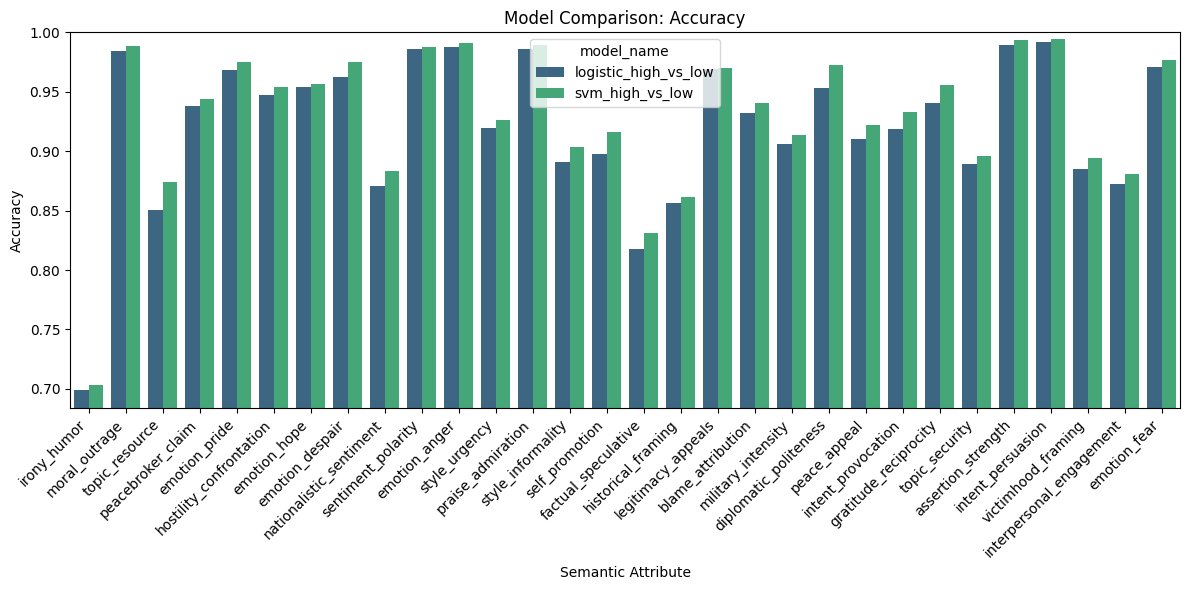

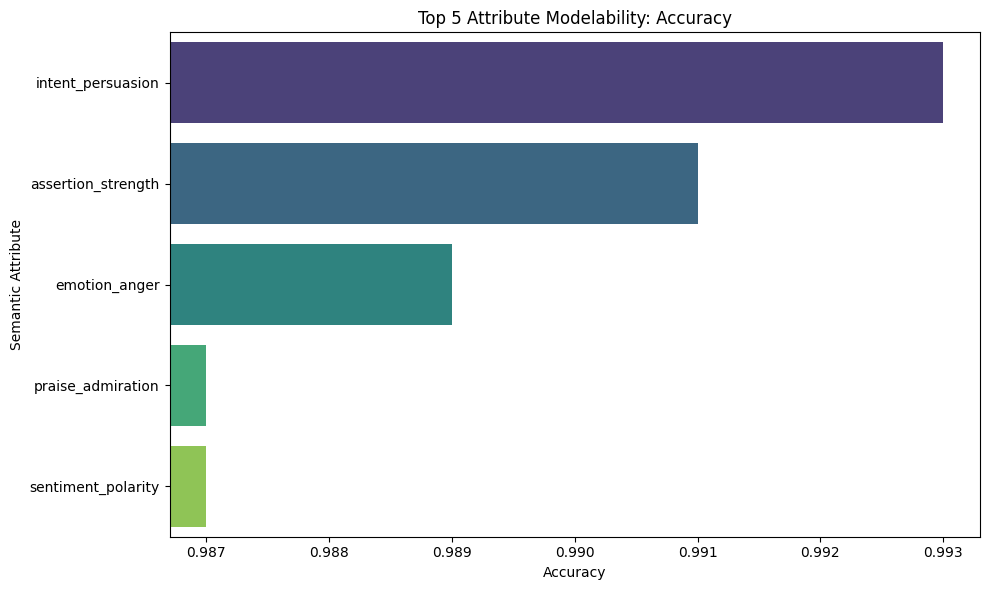

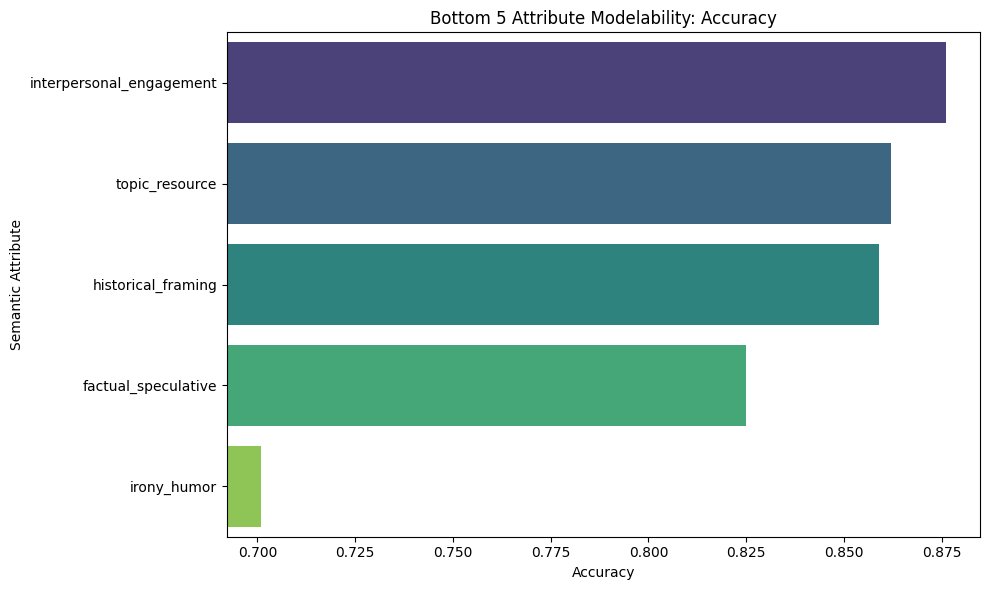

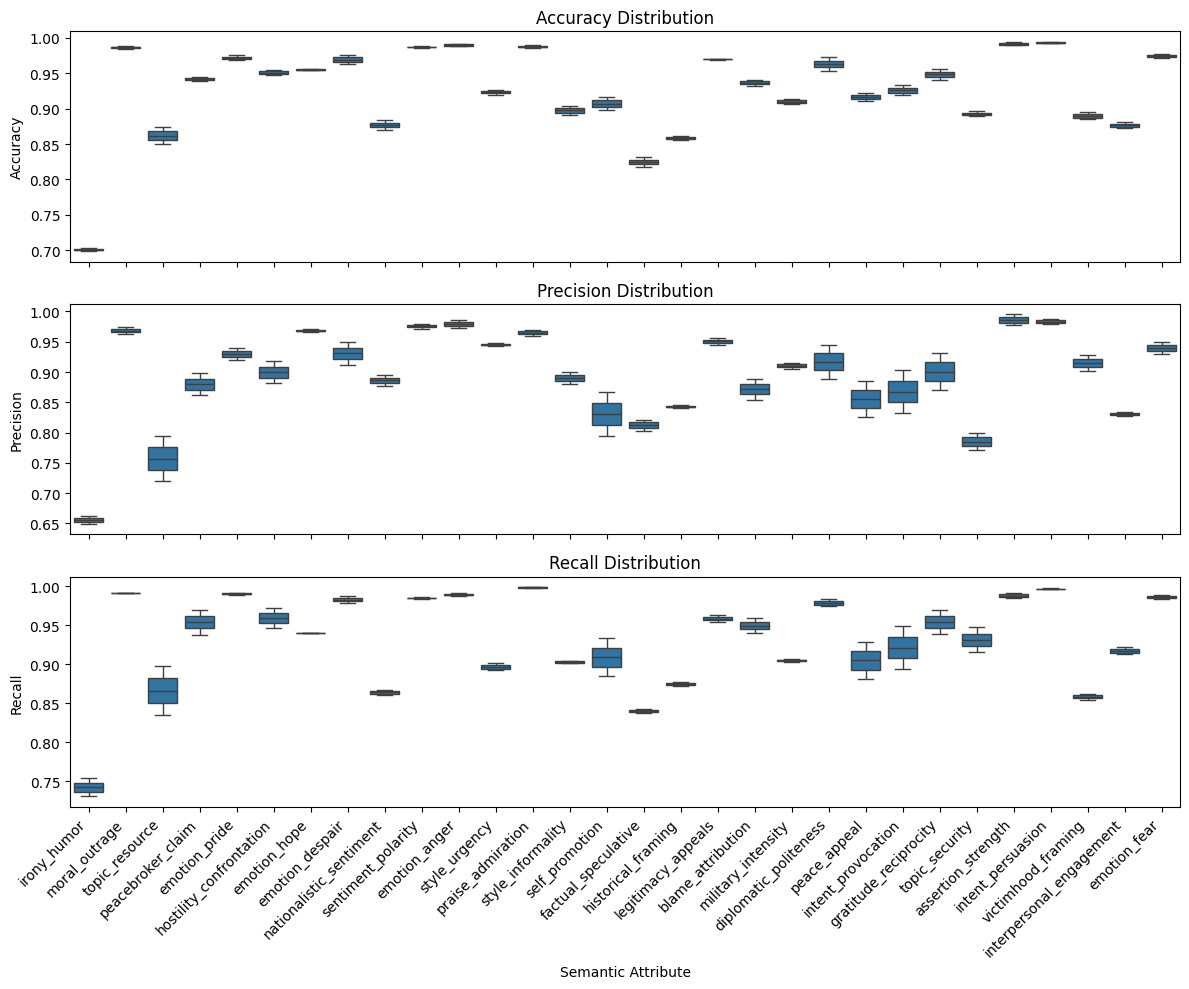

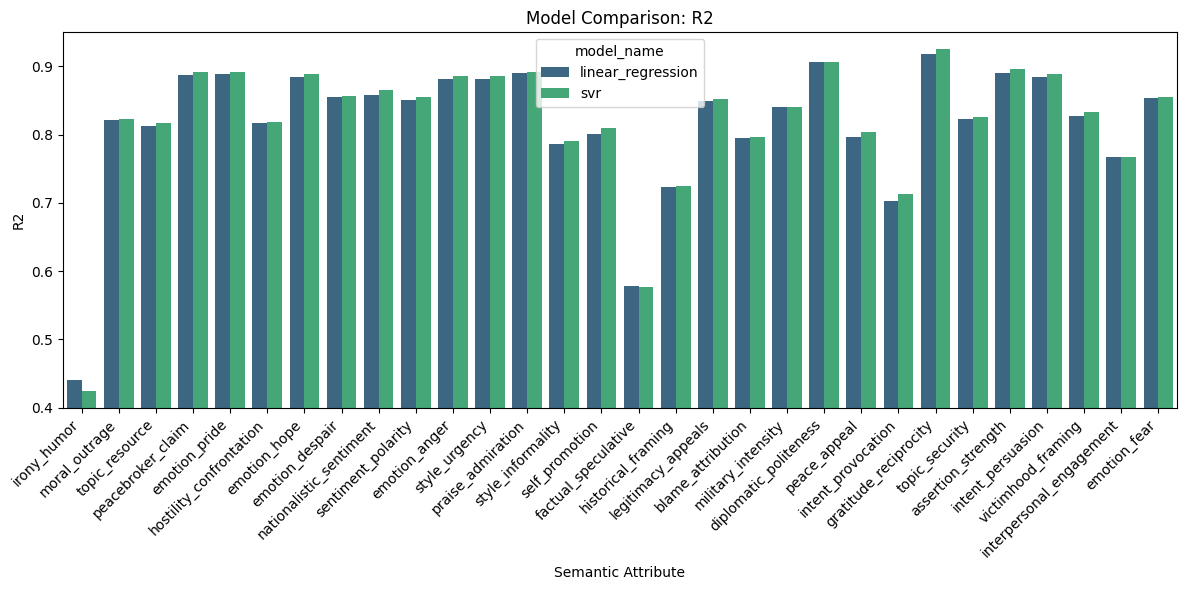

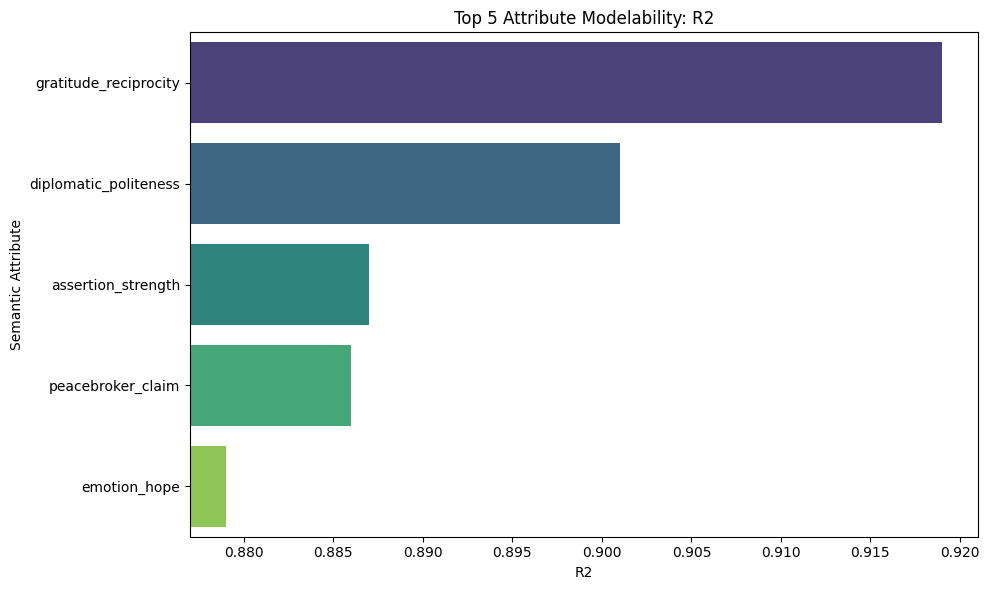

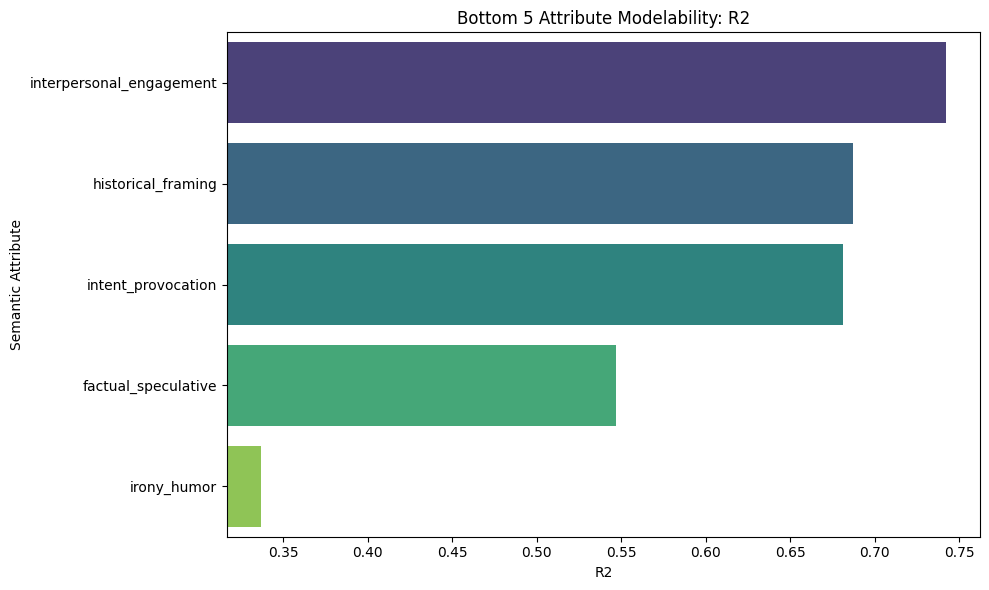

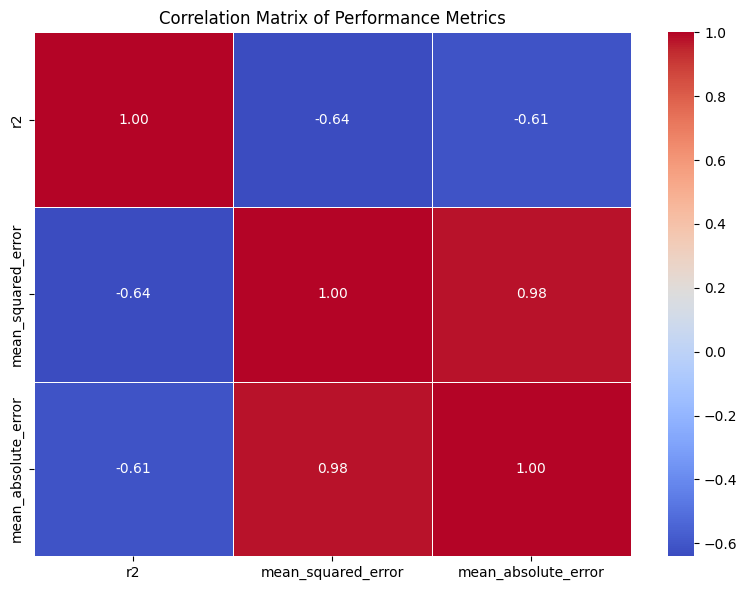

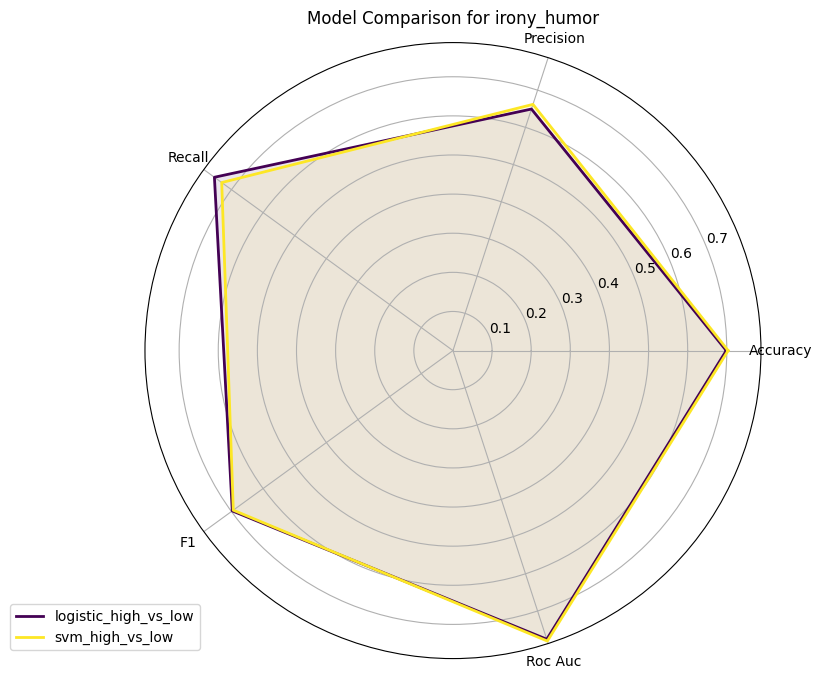

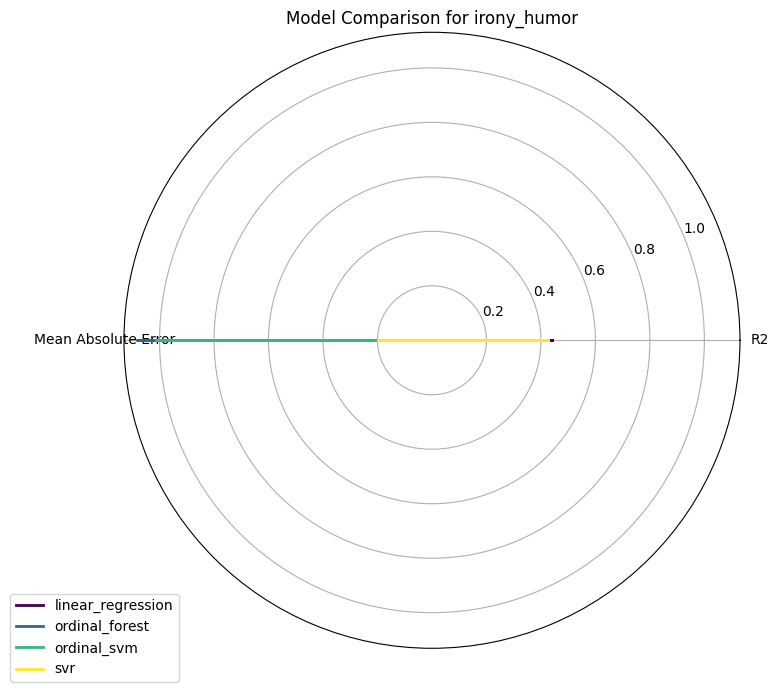

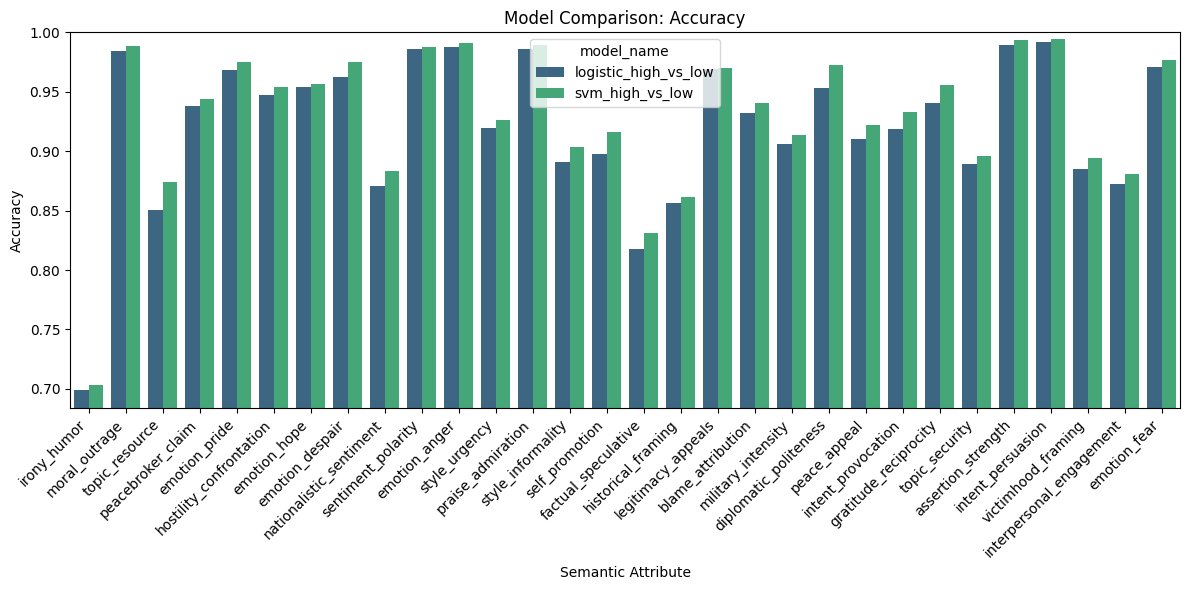

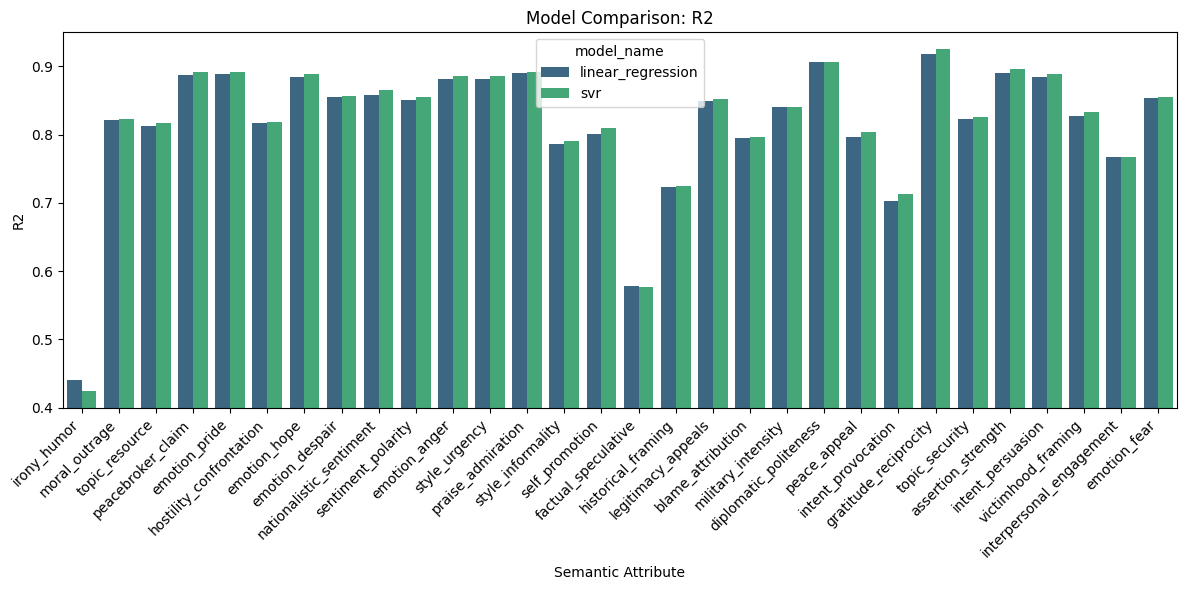

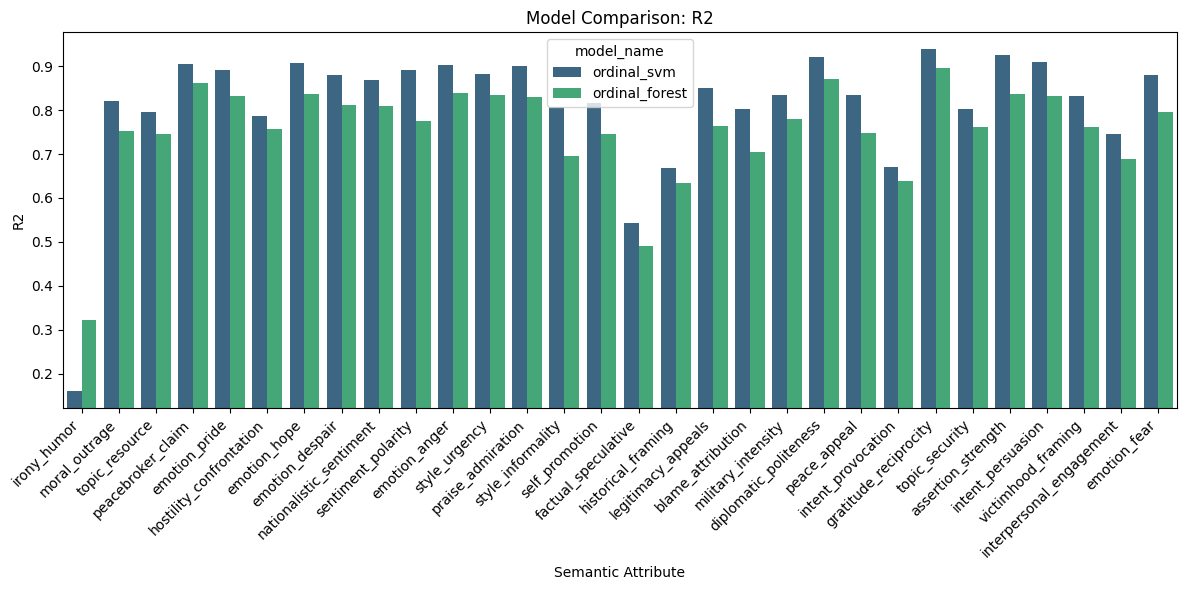

In [109]:
report = analyze_all(classifier_stats, regression_stats)

In [ ]:
t = report['classifier_analyzer']

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_format_table',
 '_validate_data',
 'attribute_column',
 'data',
 'data_type_column',
 'filter_data',
 'generate_attribute_modelability_table',
 'generate_model_comparison_table',
 'get_attributes',
 'get_data_types',
 'get_metrics',
 'get_models',
 'model_type_column',
 'relevant_metrics',
 'visualize_attribute_modelability',
 'visualize_correlation_matrix',
 'visualize_metric_distributions',
 'visualize_model_comparison',
 'visualize_performance_radar']

In [28]:
classifier_stats

,semantic_attribute,model_name,data_type,n_splits,accuracy,train_accuracy,accuracy_std,precision,train_precision,precision_std,recall,train_recall,recall_std,f1,train_f1,f1_std,roc_auc,train_roc_auc,roc_auc_std
0,irony_humor,logistic_high_vs_low,binary,10,0.698714,0.724532,0.027618,0.649228,0.672515,0.036015,0.753824,0.785649,0.032927,0.697346,0.724683,0.032155,0.775934,0.806506,0.022682
1,irony_humor,svm_high_vs_low,binary,10,0.703426,0.737066,0.028709,0.661808,0.694980,0.038637,0.730764,0.766743,0.037109,0.694103,0.729073,0.033428,0.780793,0.819717,0.024115
2,moral_outrage,logistic_high_vs_low,binary,10,0.984250,0.985058,0.004366,0.962651,0.964689,0.014357,0.990885,0.991435,0.007318,0.976478,0.977878,0.007026,0.997950,0.998096,0.001783
3,moral_outrage,svm_high_vs_low,binary,10,0.988127,0.989554,0.004393,0.973702,0.977449,0.014190,0.990885,0.991517,0.007318,0.982136,0.984432,0.006934,0.998224,0.998532,0.001767
4,topic_resource,logistic_high_vs_low,binary,10,0.850096,0.855993,0.022752,0.719964,0.725168,0.045175,0.897519,0.908875,0.025982,0.798117,0.806691,0.031019,0.939656,0.944001,0.009374
5,topic_resource,svm_high_vs_low,binary,10,0.873754,0.883492,0.017674,0.793975,0.809826,0.042135,0.835298,0.846359,0.031515,0.813381,0.827673,0.029151,0.945333,0.951844,0.007711
6,peacebroker_claim,logistic_high_vs_low,binary,10,0.938419,0.939015,0.017747,0.862065,0.862613,0.040346,0.969854,0.972121,0.020116,0.912359,0.914095,0.027701,0.984964,0.986386,0.005795
7,peacebroker_claim,svm_high_vs_low,binary,10,0.944017,0.949719,0.013806,0.898301,0.907159,0.038741,0.938210,0.946175,0.023672,0.917218,0.926254,0.022916,0.986658,0.988363,0.005648
8,emotion_pride,logistic_high_vs_low,binary,10,0.968145,0.969252,0.008018,0.920306,0.922214,0.019523,0.991573,0.993305,0.011826,0.954483,0.956439,0.012239,0.994919,0.995616,0.003529
9,emotion_pride,svm_high_vs_low,binary,10,0.974974,0.977595,0.008208,0.940075,0.945222,0.018971,0.989160,0.991538,0.010622,0.963891,0.967825,0.011948,0.996337,0.997083,0.002699


In [35]:
t = classifier_stats.columns == 'accuracy'
# index of first True value of t
first_true_index = t.argmax()


In [ ]:
classifier_model_names = classifier_stats['model_name'].unique()
classifier_metrics = classifier_stats.columns[(classifier_stats.columns == 'accuracy').argmax():]
# group classifier_metrics, and 
# plot the distribution of each of the classifier_metrics
# for each model_name (classifier_model_names)
import seaborn as sns



Index(['accuracy', 'train_accuracy', 'accuracy_std', 'precision',
       'train_precision', 'precision_std', 'recall', 'train_recall',
       'recall_std', 'f1', 'train_f1', 'f1_std', 'roc_auc', 'train_roc_auc',
       'roc_auc_std'],
      dtype='object')

In [29]:
regression_stats

,semantic_attribute,model_name,data_type,n_splits,mean_squared_error,train_mean_squared_error,mean_squared_error_std,mean_absolute_error,train_mean_absolute_error,mean_absolute_error_std,r2,train_r2,r2_std
0,irony_humor,linear_regression,numerical,10,0.059070,0.053365,0.001911,0.199593,0.189407,0.002902,0.439852,0.496178,0.035122
1,irony_humor,svr,numerical,10,0.060634,0.052139,0.002502,0.198433,0.182252,0.003046,0.424577,0.507758,0.045191
2,irony_humor,ordinal_svm,ordinal,10,2.208509,1.955162,0.179149,1.012222,0.887903,0.057478,0.160868,0.261669,0.095807
3,irony_humor,ordinal_forest,ordinal,10,1.787896,0.347037,0.085757,1.084519,0.345929,0.027009,0.322472,0.868940,0.039247
4,moral_outrage,linear_regression,numerical,10,0.020678,0.019010,0.001770,0.115672,0.110912,0.005997,0.821773,0.836736,0.014680
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,interpersonal_engagement,ordinal_forest,ordinal,10,0.803975,0.117905,0.076444,0.611112,0.117700,0.031731,0.688569,0.954408,0.025209
116,emotion_fear,linear_regression,numerical,10,0.016961,0.015760,0.000786,0.105130,0.101349,0.002822,0.853737,0.864463,0.007962
117,emotion_fear,svr,numerical,10,0.016828,0.015107,0.000785,0.104375,0.099277,0.002656,0.854892,0.870083,0.007889
118,emotion_fear,ordinal_svm,ordinal,10,0.346821,0.311173,0.025947,0.313947,0.277809,0.018848,0.880312,0.892959,0.010405


## Mood learning scrap

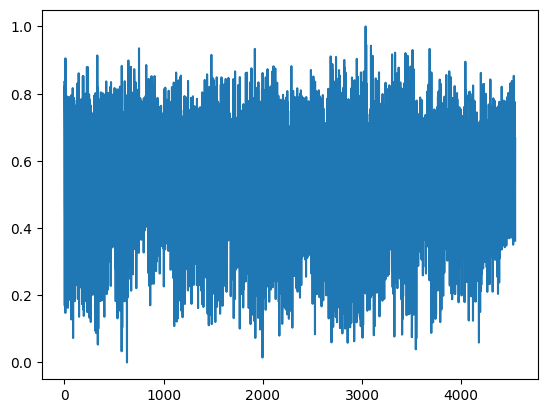

In [22]:
import matplotlib.pyplot as plt

plt.plot(mood_scores)

In [8]:
import numpy as np
import pandas as pd

def x_and_y_with_boolean_y(data, x_col, y_col, y_is_true_vals, y_is_false_vals=None):
    """
    Get the x and y values from a dataframe. 
    The output y elements will be 1, if and only if, the y_col is in y_is_true_vals.
    If y_is_false_vals is None, then all non 1 values are considered 0.
    If y_is_false_vals is not None, then all values in y_is_false_vals are considered 0,
    and all other values that are neither 0 or 1 will be NaN.
    All NaN values will be dropped.

    Args:
        data (pd.DataFrame): The dataframe to get the x and y values from.
        x_col (str): The name of the column to use as x.
        y_col (str): The name of the column to use as y.
        y_is_true_vals (list): The values in y_col that are considered 1.
        y_is_false_vals (list, optional): The values in y_col that are considered 0. Defaults to None.

    Returns:
        tuple: A tuple containing the x and y values.

    >>> import pandas as pd
    >>> data = pd.DataFrame({
    ...     'explanatory': [1, 2, 3, 4, 5],
    ...     'target': ['cat', 'dog', 'cat', 'dog', 'cow']
    ... })
    >>> X, y = x_and_y_with_boolean_y(data, 'explanatory', 'target', ['cat'])
    >>> X
    array([1, 2, 3, 4, 5])
    >>> y
    array([1, 0, 1, 0, 0])
    >>> X, y = x_and_y_with_boolean_y(data, 'explanatory', 'target', ['cat'], ['dog'])
    >>> X
    array([1, 2, 3, 4])
    >>> y
    array([1, 0, 1, 0])
    """
    # Extract feature column X as numpy array
    X = np.array(data[x_col])
    
    # Convert y_is_true_vals to set if it's a string
    if isinstance(y_is_true_vals, str):
        y_is_true_vals = {y_is_true_vals}
    else:
        y_is_true_vals = set(y_is_true_vals)
    
    # Get y values from dataframe
    y_values = data[y_col].values
    
    # Initialize y as zeros
    y = np.zeros(len(X))
    
    # Process false values 
    if y_is_false_vals is None:
        # If no false values specified, all non-true values are 0 (already set)
        pass
    else:
        # Convert y_is_false_vals to set if it's a string
        if isinstance(y_is_false_vals, str):
            y_is_false_vals = {y_is_false_vals}
        else:
            y_is_false_vals = set(y_is_false_vals)
        
        # Initialize with NaN values for elements that are neither true nor false
        y = np.full(len(X), np.nan)
        
        # Set false values
        for i, val in enumerate(y_values):
            if val in y_is_false_vals:
                y[i] = 0
    
    # Set true values
    for i, val in enumerate(y_values):
        if val in y_is_true_vals:
            y[i] = 1
    
    # Drop NaN values if needed
    if y_is_false_vals is not None:
        mask = ~np.isnan(y)
        X = X[mask]
        y = y[mask]
    
    # Ensure integer dtype
    y = y.astype(int)
    
    return X, y

if __name__ == "__main__":
    import doctest
    doctest.testmod()


In [9]:
import mood 

mood

<module 'mood' from '/Users/thorwhalen/Dropbox/py/proj/misc/infinvest/mood/mood/__init__.py'>